In [1]:
#attempt to improve the NN
#add the local and the global view construct coz transit false positive mismatch seems to be a major problem
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
#network and training parameters:
BATCH_SIZE = 128
VERBOSE = 1 #no idea what this is but lets see...
VAL_SPLIT = 0.12 #how much of sample is reserved for validation

In [14]:
#read the data from the official S and V nn
# Create a description of the features.
Xtrain=[]
Ytrain=[]
Xtrainl=[]
Xval=[]
Yval=[]
Xvall=[]
Xtest=[]
Ytest=[]
Xtestl=[]

feature_description = {
    'global_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'local_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'av_training_set': tf.io.FixedLenFeature([], tf.string, default_value=''), 
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

def one_hot(val):
    val=val.decode("utf-8") 
    if(val=='AFP'): return([0,1])
    elif(val=='PC'):  return([1,0])
    elif(val=='NTP'): return([0,1])

raw_data1=tf.data.TFRecordDataset(['train-00000-of-00008'])
raw_data2=tf.data.TFRecordDataset(['train-00001-of-00008'])
raw_data3=tf.data.TFRecordDataset(['train-00002-of-00008'])
raw_data4=tf.data.TFRecordDataset(['train-00003-of-00008'])
raw_data5=tf.data.TFRecordDataset(['train-00004-of-00008'])
raw_data6=tf.data.TFRecordDataset(['train-00005-of-00008'])
raw_data7=tf.data.TFRecordDataset(['train-00006-of-00008'])
raw_data8=tf.data.TFRecordDataset(['train-00007-of-00008'])
raw_val=tf.data.TFRecordDataset(['val-00000-of-00001'])
raw_test=tf.data.TFRecordDataset(['test-00000-of-00001'])

parsed_dataset1 = raw_data1.map(_parse_function)
parsed_dataset2 = raw_data2.map(_parse_function)
parsed_dataset3 = raw_data3.map(_parse_function)
parsed_dataset4 = raw_data4.map(_parse_function)
parsed_dataset5 = raw_data5.map(_parse_function)
parsed_dataset6 = raw_data6.map(_parse_function)
parsed_dataset7 = raw_data7.map(_parse_function)
parsed_dataset8 = raw_data8.map(_parse_function)
parsed_val = raw_val.map(_parse_function)
parsed_test = raw_test.map(_parse_function)

[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset1]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset2]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset3]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset4]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset5]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset6]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset7]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset8]
[Yval.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_val]
[Ytest.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_test]

[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset1]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset2]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset3]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset4]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset5]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset6]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset7]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset8]
[Xval.append(raw['global_view'].numpy()) for raw in parsed_val]
[Xtest.append(raw['global_view'].numpy()) for raw in parsed_test]

[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset1]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset2]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset3]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset4]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset5]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset6]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset7]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset8]
[Xvall.append(raw['local_view'].numpy()) for raw in parsed_val]
[Xtestl.append(raw['local_view'].numpy()) for raw in parsed_test]

Xtrain=np.array(Xtrain)
Xval=np.array(Xval)
Xtest=np.array(Xtest)
Xtrainl=np.array(Xtrainl)
Xvall=np.array(Xvall)
Xtestl=np.array(Xtestl)
Ytrain=np.array(Ytrain)
Ytest=np.array(Ytest)
Yval=np.array(Yval)
print(Xtrain.shape,Xval.shape,Xtest.shape)
print(Xtrainl.shape,Xvall.shape,Xtestl.shape)
print(Ytrain.shape,Yval.shape,Ytest.shape)

(12589, 2001) (1574, 2001) (1574, 2001)
(12589, 201) (1574, 201) (1574, 201)
(12589, 2) (1574, 2) (1574, 2)


In [15]:
print('training planets:',(Ytrain[:,0]==1).sum())
print('training fps:',(Ytrain[:,0]==0).sum())
print('test planets:',(Ytest[:,0]==1).sum())
print('test fps:',(Ytest[:,0]==0).sum())

minind=min((Ytrain[:,0]==1).sum(),(Ytrain[:,0]==0).sum())
filtind=[i for i in range(0,len(Ytrain)) if (Ytrain[i]==np.array([1,0])).all()]
filtind2=[i for i in range(0,len(Ytrain)) if (Ytrain[i]==np.array([0,1])).all()]
print(len(filtind),len(filtind2)) 
#print(min(len(filtind[0]),len(filtind2[0])))
temp1=[]
temp2=[] 
templ=[]  
for i in range(0,min(len(filtind),len(filtind2))):
    temp1.append(Xtrain[filtind[i]])
    temp2.append(Ytrain[filtind[i]])
    templ.append(Xtrainl[filtind[i]])
    temp1.append(Xtrain[filtind2[i]])
    temp2.append(Ytrain[filtind2[i]])
    templ.append(Xtrainl[filtind2[i]])

Xtrain=np.array(temp1)
Ytrain=np.array(temp2)
Xtrainl=np.array(templ)

temp1=[]
temp2=[] 
templ=[]  
filtind=[i for i in range(0,len(Yval)) if (Yval[i]==np.array([1,0])).all()]
filtind2=[i for i in range(0,len(Yval)) if (Yval[i]==np.array([0,1])).all()]
print(len(filtind),len(filtind2))
for i in range(0,min(len(filtind),len(filtind2))):
    temp1.append(Xval[filtind[i]])
    temp2.append(Yval[filtind[i]])
    templ.append(Xvall[filtind[i]])
    temp1.append(Xval[filtind2[i]])
    temp2.append(Yval[filtind2[i]])
    templ.append(Xvall[filtind2[i]])

Xval=np.array(temp1)
Yval=np.array(temp2)
Xvall=np.array(templ)

print(Xtrain.shape,Xval.shape)
print(Xtrainl.shape,Xvall.shape)
print(Ytrain.shape,Yval.shape)


training planets: 2885
training fps: 9704
test planets: 360
test fps: 1214
2885 9704
355 1219
(5770, 2001) (710, 2001)
(5770, 201) (710, 201)
(5770, 2) (710, 2)


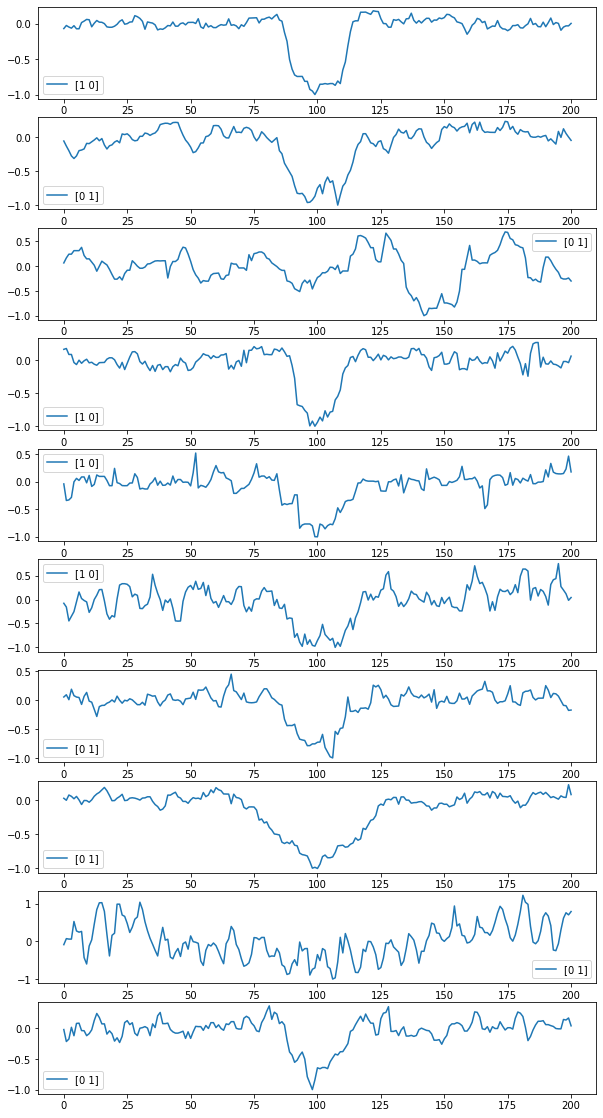

In [52]:
fig,ax=plt.subplots(10,1,figsize=(10,20))

i=0
tab=0
while tab<10:
    ax[tab].plot(Xtrainl[i],label=(Ytrain[i]))
    ax[tab].legend()
    tab+=1
    i+=1

In [3]:
#X_train=np.loadtxt('training_data/Xtrain_av_clean.csv',delimiter=',')
#X_trainl=np.loadtxt('training_data/Xtrainloc_av_clean.csv',delimiter=',')
#Y_train=np.loadtxt('training_data/Ytrain_av_clean.csv',delimiter=',')

#X_train=[el-np.median(el) for el in X_train]
#X_train=[el/np.abs(el[np.argmin(el)]) for el in X_train]
#X_train=np.array(X_train)
#X_trainl=[el-np.median(el) for el in X_trainl]
#X_trainl=[el/np.abs(el[np.argmin(el)]) for el in X_trainl]
#X_trainl=np.array(X_trainl)
#Ytrain_ref=np.loadtxt('training_data/YtrainR_big.csv',delimiter=',')
#Ytest_ref=np.loadtxt('training_data/YtestR_big.csv',delimiter=',')
#Xtrain, Xtest, Xtrainl, Xtestl, Ytrain, Ytest = train_test_split(X_train, X_trainl, Y_train, test_size=0.1)
#print(Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape)

(3220, 2000) (3220, 2) (358, 2000) (358, 2)


In [4]:
#got the training set ... now write the neural net
#buid the model
#SGD stochastic gradient descent... 
DROPOUT=0.3
IP=3220
TEST=358
np.random.seed(11223)
#clean data has 1805 FPS and 2117 planets

'''
conv_ip = keras.layers.Input(shape=(2000,),name='Input')
x=keras.layers.Reshape((2000, 1), input_shape=(2000,),name='reshape_1')(conv_ip)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Conv1D(16,kernel_size=5,strides=2,activation='relu',name='conv16_5')(x) 
x=keras.layers.Conv1D(16,kernel_size=5,strides=2,activation='relu',name='second_conv16_5')(x)
checkf=keras.layers.MaxPool1D(3,strides=3,data_format='channels_last',name='maxpool_1')(x)
x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='first_conv32_5')(checkf)
x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='second_conv32_5')(x)
x=keras.layers.MaxPool1D(3,strides=3,data_format='channels_last',name='maxpool_2')(x)
x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='conv64_5')(x)
x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='conv64_5_2')(x)
x=keras.layers.MaxPool1D(3,strides=3,data_format='channels_last',name='maxpool_3')(x)
x=keras.layers.Flatten(name='flat_1')(x)
x=keras.layers.Dense(16,name='dense_layer_1',activation='relu')(x)
conv_op=keras.layers.Dense(3,name='dense_layer_2',activation='softmax')(x)


convNN = keras.Model(inputs=conv_ip, outputs=conv_op,name='Convolutional_NN')

featuresNN = keras.Model(inputs=conv_ip, outputs=checkf)

convNN.summary()
convNN.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])'''

#kernel_size = 5
#kernel = np.ones(kernel_size) / kernel_size
#Xtrain = [np.convolve(Xtrain[i], kernel, mode='same') for i in range(IP)]
#Xtest = [np.convolve(Xtest[i], kernel, mode='same') for i in range(TEST)]

"\nconv_ip = keras.layers.Input(shape=(2000,),name='Input')\nx=keras.layers.Reshape((2000, 1), input_shape=(2000,),name='reshape_1')(conv_ip)\nx=keras.layers.BatchNormalization()(x)\nx=keras.layers.Conv1D(16,kernel_size=5,strides=2,activation='relu',name='conv16_5')(x) \nx=keras.layers.Conv1D(16,kernel_size=5,strides=2,activation='relu',name='second_conv16_5')(x)\ncheckf=keras.layers.MaxPool1D(3,strides=3,data_format='channels_last',name='maxpool_1')(x)\nx=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='first_conv32_5')(checkf)\nx=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='second_conv32_5')(x)\nx=keras.layers.MaxPool1D(3,strides=3,data_format='channels_last',name='maxpool_2')(x)\nx=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='conv64_5')(x)\nx=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='conv64_5_2')(x)\nx=keras.layers.MaxPool1D(3,strides=3,data_format='channels_last',name='maxpool_3')

In [16]:

#add hidden layers
conv_ip = keras.layers.Input(shape=(2001,),name='Input')
conv_ipl = keras.layers.Input(shape=(201,),name='LInput')
x=keras.layers.Reshape((2001, 1), input_shape=(2001,),name='reshape_1')(conv_ip)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='conv16_5')(x) 
x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='second_conv16_5')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_1')(x)
x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='first_conv32_5')(x)
x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='second_conv32_5')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_2')(x)
x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='first_conv64_5')(x)
x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv64_5')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_3')(x)
x=keras.layers.Conv1D(128,kernel_size=5,strides=1,activation='relu',name='first_conv128_5')(x)
x=keras.layers.Conv1D(128,kernel_size=5,strides=1,activation='relu',name='second_conv128_5')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_4')(x)
x=keras.layers.Conv1D(256,kernel_size=5,strides=1,activation='relu',name='first_conv256_5')(x)
x=keras.layers.Conv1D(256,kernel_size=5,strides=1,activation='relu',name='second_conv256_5')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_5')(x)
x=keras.layers.Flatten(name='flat_1')(x)
x=keras.Model(conv_ip,x,name='global')

x2=keras.layers.Reshape((201, 1), input_shape=(201,),name='Lreshape_1')(conv_ipl)
x2=keras.layers.BatchNormalization()(x2)
x2=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='Lconv16_5')(x2) 
x2=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='Lsecond_conv16_5')(x2)
x2=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='Lmaxpool_1')(x2)
x2=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='Lfirst_conv32_5')(x2)
x2=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='Lsecond_conv32_5')(x2)
x2=keras.layers.MaxPool1D(5 ,strides=2,data_format='channels_last',name='Lmaxpool_2')(x2)
x2=keras.layers.Flatten(name='flat_2')(x2)
x2=keras.Model(conv_ipl,x2,name='global')

x3=keras.layers.concatenate([x.output,x2.output],name="combine")

x3=keras.layers.Dense(512,name='dense_layer_1',activation='relu')(x3)
x3=keras.layers.Dense(512,name='dense_layer_2',activation='relu')(x3)
x3=keras.layers.Dense(512,name='dense_layer_3',activation='relu')(x3)
x3=keras.layers.Dense(512,name='dense_layer_u',activation='relu')(x3)
x3=keras.layers.Dense(1,name='dense_layer_4',activation='relu')(x3)
conv_op=keras.layers.Dense(2,name='dense_layer_5',activation='softmax')(x3)


convNN = keras.Model(inputs=[conv_ip,conv_ipl], outputs=conv_op,name='Convolutional_NN')


convNN.summary()
convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005,beta_1=0.9,beta_2=0.999,epsilon=10**(-8)),
     loss='categorical_crossentropy',metrics=['accuracy'])

Model: "Convolutional_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 2001)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2001, 1)      0           Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2001, 1)      4           reshape_1[0][0]                  
__________________________________________________________________________________________________
conv16_5 (Conv1D)               (None, 1997, 16)     96          batch_normalization[0][0]        
___________________________________________________________________________________

In [17]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
history=convNN.fit([np.array(Xtrain),np.array(Xtrainl)],np.array(Ytrain), batch_size=64, epochs=30, verbose=VERBOSE, 
    validation_data=([Xval,Xvall],Yval))

Epoch 1/30
91/91 [==============================] - 69s 734ms/step - loss: 0.5746 - accuracy: 0.7281 - val_loss: 0.5808 - val_accuracy: 0.9028
Epoch 2/30
91/91 [==============================] - 68s 752ms/step - loss: 0.4780 - accuracy: 0.9078 - val_loss: 0.4837 - val_accuracy: 0.9352
Epoch 3/30
91/91 [==============================] - 64s 707ms/step - loss: 0.4662 - accuracy: 0.9144 - val_loss: 0.4304 - val_accuracy: 0.9338
Epoch 4/30
91/91 [==============================] - 59s 653ms/step - loss: 0.4499 - accuracy: 0.9251 - val_loss: 0.4336 - val_accuracy: 0.9465
Epoch 5/30
91/91 [==============================] - 64s 703ms/step - loss: 0.4362 - accuracy: 0.9333 - val_loss: 0.4134 - val_accuracy: 0.9479
Epoch 6/30
91/91 [==============================] - 69s 761ms/step - loss: 0.4316 - accuracy: 0.9310 - val_loss: 0.4159 - val_accuracy: 0.9423
Epoch 7/30
91/91 [==============================] - 65s 713ms/step - loss: 0.4331 - accuracy: 0.9296 - val_loss: 0.4187 - val_accuracy: 0.9352

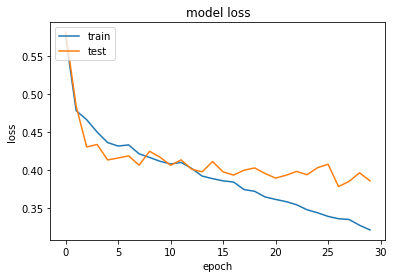

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Mloss_SandN_tot_actual_un.png')
plt.show()

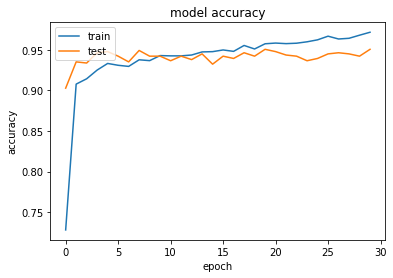

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('macc_SandN_actual_un.png')
plt.show()

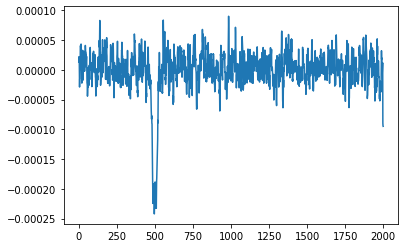

In [9]:
#testing the feature map
#Y=featuresNN.predict(np.array(Xtrain[:10]))
#sep=[[Y[i][j][1] for i in range(10)] for j in range(7)]
#plt.imshow(sep)
plt.plot(Xtrain[4])
#[plt.scatter(i,Y[0][i][2],color='green') for i in range(0,7)]
#[plt.scatter(i,Y[0][i][3],color='black') for i in range(0,7)]
plt.show()

In [20]:
test_loss, test_acc = convNN.evaluate([np.array(Xtest),np.array(Xtestl)], np.array(Ytest))
print('Test accuracy:', test_acc)
Ypred_raw=convNN.predict([np.array(Xtest),np.array(Xtestl)])
Ypred=np.argmax(Ypred_raw, axis=1)
Ytest_new=np.argmax(Ytest,axis=1)
cm = confusion_matrix(Ytest_new, Ypred)
print(cm)

50/50 [==============================] - 4s 88ms/step - loss: 0.6302 - accuracy: 0.9358
Test accuracy: 0.9358322620391846
[[ 341   19]
 [  82 1132]]


In [21]:
convNN.save_weights('conv_LocalGlobal_main_un.h5')